In [58]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [59]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [60]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [61]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [62]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [63]:
def SCAI_index(prec_sm,bt_sm):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    N_prec = np.zeros(prec_sm.shape[0]) # prec_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    SCAI_p = np.zeros(prec_sm.shape[0]) # cldfrac over domain by prec criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=240,flag=2) # less than 240 W/m^2
        SCAI_BT[t] = scai.SCAI_calc(label_obj,N,dx=0.25*100000,L=10*100000)
        N_psT[t] = N
    
    for t in range(prec_sm.shape[0]):
        label_obj, N = scai.labeled_obj(prec_sm[t,:,:].values,cri=1,flag=1) # larger than 1mm/day
        SCAI_p[t] = scai.SCAI_calc(label_obj,N,dx=0.25*100000,L=10*100000)    
        N_prec[t] = N

    return (SCAI_BT,SCAI_p,N_psT,N_prec)

In [64]:
warnings.filterwarnings('ignore')

In [65]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

### Read data_event from written .dat files

In [66]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [67]:
os.chdir('/data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [68]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event < lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event < lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [69]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [70]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [71]:
len(time_event)

108419

In [72]:
os.chdir('/data/willytsai/ISCCP')
# T_all = np.load('T_all_5deg_4ds.mat.npy') #
# q_all = np.load('q_all_5deg_4ds.mat.npy') #
# u_all = np.load('u_all_5deg_4ds.mat.npy') #
# v_all = np.load('v_all_5deg_4ds.mat.npy') #
N_all = np.load('N_all_5deg_4ds.mat.npy') #
SCAIbt_all = np.load('SCAIbt_all_5deg_4ds.mat.npy') #
Iorg_all = np.load('Iorg2_all_5deg_4ds.mat.npy')
bt_all = np.load('bt_all_5deg_4ds.mat.npy') #
#llws_all = np.load('llws_all_5deg.mat.npy')
prec_all = np.load('prec_all_5deg_4ds.mat.npy') #
cwv_all = np.load('cwv_all_5deg_4ds.mat.npy') #
crh_all = np.load('crh_all_5deg_4ds.mat.npy')

omega_all = np.load('omega_all_5deg_4ds.mat.npy') #
# rh_all = np.load('rh_all_5deg_4ds.mat.npy')
#cwvstd_all = np.load('cwvstd_all.mat.npy')
#SF_all = np.load('SF_all.mat.npy')
cldfrac_all = np.load('cldfrac_all_5deg_4ds.mat.npy') #
#CFv_all = np.load('CFv_all.mat.npy')
div_all  = np.load('div_all_5deg_4ds.mat.npy') #
# cwvten_dyn_all = np.load('cwvten_dyn_all_5deg.mat.npy')
# cwvten_phy_all = np.load('cwvten_phy_all_5deg.mat.npy')
# cwvten_ana_all = np.load('cwvten_ana_all_5deg.mat.npy')
#cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all
Abar_all = (cldfrac_all/N_all*2500*(10*10))**0.5 # square root of Area [km] #
#cape_all = np.load('cape_all.mat.npy')
#cin_all = np.load('cin_all.mat.npy')

# cldamt_call_all = np.load('cldamt_call_all_5deg_4ds.mat.npy') #
# cldamt_cu_all = np.load('cldamt_cu_all_5deg_4ds.mat.npy') #
# cldamt_st_all = np.load('cldamt_st_all_5deg_4ds.mat.npy') #
# cldamt_dc_all = np.load('cldamt_dc_all_5deg_4ds.mat.npy') #

# LHF_all = np.load('LHF_all_5deg_4ds.mat.npy') #
# SHF_all = np.load('SHF_all_5deg_4ds.mat.npy') #
#qvflux_all = np.load('qvfluxm_all_5deg_4ds.mat.npy') #
qvflux_all = np.load('qvflux_all_5deg_4ds.mat.npy') #

#ctp_all = np.load('ctpir_all_5deg.mat.npy')
precM2_all = np.load('precM2_all_5deg_4ds.mat.npy') #
# TQL_all = np.load('TQL_all.mat_5deg.npy')
# TQI_all = np.load('TQI_all.mat_5deg.npy')
# TQLI_all = TQL_all + TQI_all; del TQL_all, TQI_all

In [73]:
def center_case(time_event,lon_event,lat_event,cri_r=300,ratio=0.5):
    'precipitation area is enclosed within a circle R at reference time'
    
    file_path = TRMM_dir+'2014_2018'
    time_cent = time_event
    lat_cent = lat_event
    lon_cent = lon_event
    
    # read preciptation data in the given domain
    data = subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=0,lat_inc=2.5,lon_inc=2.5)
    prec_sm = data.precipitation.squeeze()
    prec_sum = np.nansum(prec_sm)

    # calculate the distance matrix
    x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
    dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]
    prec_sm.values[dist > cri_r] = 0
    prec_frac = (np.nansum(prec_sm)/prec_sum)
    
    if prec_frac >= ratio:
        result = 1
    else:
        result = 0

    return result

In [99]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        tmp = np.fft.fft(data_all[n,:]) # 49
        freqs = np.array(range(NT))   # This gets the left end correct
        reversed_freqs = freqs[::-1]  # Reverse the array 
        reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
        freqs = reversed_freqs[::-1]  # reverse it back 
        tmp[np.where(freqs==4)] = 0 # remove diurnal 6 cycles for 6 days
        tmp[np.where(freqs==8)] = 0 # remove half-day
        tmp[np.where(freqs==9)] = 0
        tmp_re[n,:] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [100]:
def remove_diurnal_2D(data_all):
    'remove diurnal cycle in the time series [N,time,lev], N cases'
    
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        for k in range(data_all.shape[2]):
            tmp = np.fft.fft(data_all[n,:,k]) # 49
            freqs = np.array(range(NT))   # This gets the left end correct
            reversed_freqs = freqs[::-1]  # Reverse the array 
            reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
            freqs = reversed_freqs[::-1]  # reverse it back 
            tmp[np.where(freqs==4)] = 0 # remove diurnal 6 cycles for 6 days
            tmp[np.where(freqs==8)] = 0 # remove half-day
            tmp[np.where(freqs==9)] = 0
            tmp_re[n,:,k] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

#### overlapping events identification and removal

In [76]:
lat_cen = np.arange(-7.5,10,2.5)
lon_cen = np.arange(-177.5,180,2.5)
idx_record = [] # idx list for final events

for lat in lat_cen:
    for lon in lon_cen:
        idx = np.where(lat_event==lat)[0]
        idy = np.where(lon_event==lon)[0]
        idx_org = np.intersect1d(idx,idy)
        
        time_frame = time_event[idx_org]
        for i,idx in enumerate(idx_org):
            if i == 0:
                if (time_frame[i+1]-time_frame[i]).days >= 4:
                    idx_record.append(idx)
            elif i == len(idx_org)-1:
                if (time_frame[i]-time_frame[i-1]).days >= 4:
                    idx_record.append(idx)
            else:
                if (time_frame[i+1]-time_frame[i]).days >= 4 and \
                   (time_frame[i]-time_frame[i-1]).days >= 4:
                    idx_record.append(idx)            

#### cloud object located at center

In [77]:
idx_cent = np.load('idx_center200kmR05_all_5deg_4ds.mat.npy') # largely remove event cut at boundary edges

In [78]:
idx_rm = np.where(idx_cent > 0)[0]

#### testing relationship between cloud coverage and TRMM prec

In [79]:
# cldfrac_bins = np.linspace(0,1.025,42)
# prec_bins = np.linspace(0,80,41)
# prec_com = np.zeros(len(cldfrac_bins)-1)
# num_com = np.zeros((len(cldfrac_bins),len(prec_bins)))

# cldfrac_1d = cldfrac_all.flatten()
# prec_1d = prec_all.flatten()*24 #[mm/day]

# for i in range(len(cldfrac_bins)-1):
#     for j in range(len(prec_bins)-1):
#         idx = np.where(np.logical_and(cldfrac_1d>=cldfrac_bins[i],cldfrac_1d<cldfrac_bins[i+1]))[0]
#         idy = np.where(np.logical_and(prec_1d>=prec_bins[j],prec_1d<prec_bins[j+1]))[0]
#         idx_com = np.intersect1d(idx,idy)
#         num_com[i,j] = len(idx_com)
        
# for n in range(len(cldfrac_bins)-1):
#     idx = np.where(np.logical_and(cldfrac_1d>=cldfrac_bins[n],cldfrac_1d<cldfrac_bins[n+1]))
#     prec_com[n] = np.nanmean(prec_1d[idx])

In [80]:
# fig = plt.figure(figsize=(6.5,5))

# plt.pcolormesh(cldfrac_bins,prec_bins,np.log10(num_com.T/np.sum(num_com)),
#              cmap='binary')
# cbar=plt.colorbar(shrink=0.8)
# cbar.set_label('Log$_{10}$(Probability)',fontsize=12)
# plt.contour(cldfrac_bins,prec_bins,np.log10(num_com.T/np.sum(num_com)),levels=[-5,-4,-3,-2,-1]
#             ,colors=['w'],linewidths=2)
# plt.plot(cldfrac_bins[:-1],prec_com,'k',linewidth=2)

# # GPI (Arkin and Meisner, 1987) Precip intensity = cldfrac x 3 mm/hr 
# prec_gpi = cldfrac_bins*3*24
# plt.plot(cldfrac_bins,prec_gpi,'--k',linewidth=1.5)

# plt.xlim([0,1]);plt.ylim([0,80])
# plt.ylabel('TRMM precip. [mm d$^{-1}$]',fontsize=14)
# plt.tick_params(labelsize=13)
# plt.xlabel('Cloud coverage' ,fontsize=14)

# fig.savefig(fig_dir+'prec_cldfrac_histogram.pdf',bbox_inches='tight')

In [81]:
#idx_rm = np.array(idx_record) # new idx with removal overlapping

In [82]:
#len(idx_rm)

In [83]:
# time_event = time_event[idx_rm]
# lat_event = lat_event[idx_rm]
# lon_event = lon_event[idx_rm]

# # T_all = T_all[idx_rm,:,:]
# # q_all = q_all[idx_rm,:,:]
# # u_all = u_all[idx_rm,:,:]
# # v_all = v_all[idx_rm,:,:]
# N_all = N_all[idx_rm,:]
# SCAIbt_all = SCAIbt_all[idx_rm,:]
# bt_all = bt_all[idx_rm,:]
# #llws_all = llws_all[idx_rm,:]
# prec_all = prec_all[idx_rm,:]
# #precstd_all = precstd_all[idx_rm,:]
# cwv_all = cwv_all[idx_rm,:]
# crh_all = crh_all[idx_rm,:]

# omega_all = omega_all[idx_rm,:,:]
# # rh_all = rh_all[idx_rm,:,:]
# #cwvstd_all = cwvstd_all[idx_rm,:]

# cldfrac_all = cldfrac_all[idx_rm,:]
# #CFv_all = CFv_all[idx_rm,:,:]
# div_all  = div_all[idx_rm,:,:]
# # cwvten_dyn_all = cwvten_dyn_all[idx_rm,:]
# # cwvten_phy_all = cwvten_phy_all[idx_rm,:]
# # cwvten_ana_all = cwvten_ana_all[idx_rm,:]
# #cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all
# Abar_all = Abar_all[idx_rm,:]
# #cape_all = cape_all[idx_rm,:]
# #cin_all = cin_all[idx_rm,:]

# # cldamt_call_all = cldamt_call_all[idx_rm,:]
# # cldamt_cu_all = cldamt_cu_all[idx_rm,:]
# # cldamt_st_all = cldamt_st_all[idx_rm,:]
# # cldamt_dc_all = cldamt_dc_all[idx_rm,:]

# qvflux_all = qvflux_all[idx_rm,:,:]
# # SHF_all = SHF_all[idx_rm,:]
# # LHF_all = LHF_all[idx_rm,:]
# #ctp_all = ctp_all[idx_rm,:]
# precM2_all = precM2_all[idx_rm,:]
# #TQLI_all = TQLI_all[idx_rm,:]

In [84]:
# remove diurnal cycle and marginal cases
# T_all = remove_diurnal_2D(T_all) 
# q_all = remove_diurnal_2D(q_all)
# u_all = remove_diurnal_2D(u_all)
# v_all = remove_diurnal_2D(v_all)
N_all = N_all
SCAIbt_all = SCAIbt_all
Iorg_all = Iorg_all
#llws_all = remove_diurnal_1D(llws_all)
bt_all = remove_diurnal_1D(bt_all)
prec_all = prec_all
#precstd_all = remove_diurnal_1D(prec_all)
cwv_all = remove_diurnal_1D(cwv_all)
crh_all = remove_diurnal_1D(crh_all)

#omega_all = remove_diurnal_2D(omega_all)
#rh_all = remove_diurnal_2D(rh_all)
#cwvstd_all = remove_diurnal_1D(cwvstd_all)
#SF_all = remove_diurnal_1D(SF_all)
cldfrac_all = cldfrac_all
#CFv_all = remove_diurnal_2D(CFv_all)
div_all  = remove_diurnal_2D(div_all); 
#cwvten_dyn_all = remove_diurnal_1D(cwvten_dyn_all)
#cwvten_phy_all = remove_diurnal_1D(cwvten_phy_all)
#cwvten_ana_all = remove_diurnal_1D(cwvten_ana_all)
#cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all;
Abar_all = Abar_all
#cape_all = remove_diurnal_1D(cape_all)
#cin_all = remove_diurnal_1D(cin_all)

# crh_q1_all = remove_diurnal_1D(crh_q1_all)
# crh_q4_all = remove_diurnal_1D(crh_q4_all)

# cwv_q1_all = remove_diurnal_1D(cwv_q1_all)
# cwv_q4_all = remove_diurnal_1D(cwv_q4_all)

# rh_q1_all = remove_diurnal_2D(rh_q1_all)
# rh_q4_all = remove_diurnal_2D(rh_q4_all)

# cldamt_call_all = cldamt_call_all
# cldamt_cu_all = cldamt_cu_all
# cldamt_st_all = cldamt_st_all
# cldamt_dc_all = cldamt_dc_all

# SHF_all = remove_diurnal_1D(SHF_all)
# LHF_all = remove_diurnal_1D(LHF_all)
# SFX_all = SHF_all + LHF_all
#TQLI_all = remove_diurnal_1D(TQLI_all)

#SFXstd_all = remove_diurnal_1D(SFXstd_all)
qvflux_all = remove_diurnal_2D(qvflux_all)
#ctp_all = ctp_all
precM2_all = precM2_all
#qvflux_all = qvflux_all

In [85]:
# deal with qvflux at the first level
for n in range(len(time_event)):
    for t in range(33):
        if np.isnan(qvflux_all[n,t,0]) == True:
            qvflux_all[n,t,0] = qvflux_all[n,t,1]

In [86]:
# remove wrong values
# idx = np.where(np.logical_or(cldamt_call_all>100,cldamt_call_all<0))
# cldamt_call_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_cu_all>100,cldamt_cu_all<0))
# cldamt_cu_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_st_all>100,cldamt_st_all<0))
# cldamt_st_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_dc_all>100,cldamt_dc_all<0))
# cldamt_dc_all[idx] = np.nan

#### Region definition

In [87]:
idx_IND = event_region(lat_event,lon_event,50,90,-10,10) # Tropical Indian Ocean
idx_WPC = event_region(lat_event,lon_event,150,180,-10,10) # Tropical Western Pacific
idx_EPC = event_region(lat_event,lon_event,-180,-90,-10,10) # Tropical Eastern Pacific

In [88]:
cldfrac_IND = cldfrac_all[idx_IND,:] # reference cloud coverage 
cldfrac_WPC = cldfrac_all[idx_WPC,:] # reference cloud coverage 
cldfrac_EPC = cldfrac_all[idx_EPC,:] # reference cloud coverage 

prec_IND = prec_all[idx_IND,:] 
prec_WPC = prec_all[idx_WPC,:] 
prec_EPC = prec_all[idx_EPC,:] 

crh_IND = crh_all[idx_IND,:] 
crh_WPC = crh_all[idx_WPC,:] 
crh_EPC = crh_all[idx_EPC,:] 

Abar_IND = Abar_all[idx_IND,:]
Abar_WPC = Abar_all[idx_WPC,:]
Abar_EPC = Abar_all[idx_EPC,:]

SCAIbt_IND = SCAIbt_all[idx_IND,:]
SCAIbt_WPC = SCAIbt_all[idx_WPC,:]
SCAIbt_EPC = SCAIbt_all[idx_EPC,:]

N_IND = N_all[idx_IND,:]
N_WPC = N_all[idx_WPC,:]
N_EPC = N_all[idx_EPC,:]

# q_IND = q_all[idx_IND,:,:]
# q_WPC = q_all[idx_WPC,:,:]
# q_EPC = q_all[idx_EPC,:,:]

# rh_IND = rh_all[idx_IND,:,:]
# rh_WPC = rh_all[idx_WPC,:,:]
# rh_EPC = rh_all[idx_EPC,:,:]

### Grouping by cldfrac and Abar

In [89]:
def idx_group(var1_all,v1_lbound,v1_ubound,var2_all,v2_lbound,v2_ubound):
    
    idx1 = np.where(np.logical_and(var1_all[:,16]>v1_lbound,var1_all[:,16]<=v1_ubound))[0]
    idx2 = np.where(np.logical_and(var2_all[:,16]>v2_lbound,var2_all[:,16]<=v2_ubound))[0]
    idx = np.intersect1d(idx1,idx2)
    
    return idx

In [90]:
# event separation by cloud cover (convective scale) and CRH 
idx_G1 = idx_group(cldfrac_all,0,0.2,cwv_all,0,100)
idx_G2 = idx_group(cldfrac_all,0.2,0.4,cwv_all,0,100)
idx_G3 = idx_group(cldfrac_all,0.4,0.6,cwv_all,0,100)
idx_G4 = idx_group(cldfrac_all,0.6,0.8,cwv_all,0,100)
idx_G5 = idx_group(cldfrac_all,0.8,1,cwv_all,0,100)

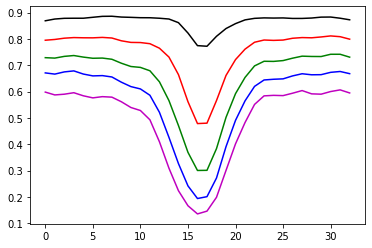

In [91]:
plt.plot(np.nanmean(Iorg_all[idx_G1,:],axis=0),'k')
plt.plot(np.nanmean(Iorg_all[idx_G2,:],axis=0),'r')
plt.plot(np.nanmean(Iorg_all[idx_G3,:],axis=0),'g')
plt.plot(np.nanmean(Iorg_all[idx_G4,:],axis=0),'b')
plt.plot(np.nanmean(Iorg_all[idx_G5,:],axis=0),'m')

### qvflux cross-section

In [ ]:
os.chdir('/data/willytsai/ISCCP')
omega_cross_all = np.load('omega_crosssect_all_lat_5deg_4ds.mat.npy')
#omega_cross_all = omega_cross_all[idx_rm,:,:]

In [ ]:
v_cross_all = np.load('v_crosssect_all_lat_5deg_4ds.mat.npy')
#v_cross_all = v_cross_all[idx_rm,:,:]
cwv_cross_all = np.load('cwv_crosssect_all_lat_5deg_4ds.mat.npy')
#cwv_cross_all = cwv_cross_all[idx_rm,:,:]

In [ ]:
cwv_r1 = np.nanmean(cwv_cross_all[idx_G1,:,:],axis=0)
cwv_r2 = np.nanmean(cwv_cross_all[idx_G2,:,:],axis=0)
cwv_r3 = np.nanmean(cwv_cross_all[idx_G3,:,:],axis=0)
cwv_r4 = np.nanmean(cwv_cross_all[idx_G4,:,:],axis=0)
cwv_r5 = np.nanmean(cwv_cross_all[idx_G5,:,:],axis=0)

In [ ]:
v_r1 = np.nanmean(v_cross_all[idx_G1,:,:,:],axis=0)
v_r2 = np.nanmean(v_cross_all[idx_G2,:,:,:],axis=0)
v_r3 = np.nanmean(v_cross_all[idx_G3,:,:,:],axis=0)
v_r4 = np.nanmean(v_cross_all[idx_G4,:,:,:],axis=0)
v_r5 = np.nanmean(v_cross_all[idx_G5,:,:,:],axis=0)

In [ ]:
omega_r1 = np.nanmean(omega_cross_all[idx_G1,:,:,:],axis=0)
omega_r2 = np.nanmean(omega_cross_all[idx_G2,:,:,:],axis=0)
omega_r3 = np.nanmean(omega_cross_all[idx_G3,:,:,:],axis=0)
omega_r4 = np.nanmean(omega_cross_all[idx_G4,:,:,:],axis=0)
omega_r5 = np.nanmean(omega_cross_all[idx_G5,:,:,:],axis=0)

In [ ]:
#qvflx_radius_all = np.load('qvflux_crosssect_all_lat_5deg_4ds.mat.npy')
#qvflx_radius_all = qvflx_radius_all[idx_rm,:,:,:]
#div_radius_all = np.load('div_crosssect_all_5deg.mat.npy')
# qadv_radius_all = np.load('qadv_crosssect_all_lat_5deg.mat.npy')
# qadv_radius_all = qadv_radius_all[idx_rm,:,:,:]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
qvflx_cross_all = np.load('qvflux_crosssect_all_uv_5deg_4ds.mat.npy')
#qvflx_cross_all = qvflx_cross_all[idx_rm,:,:,:]

In [ ]:
# qvflx_r1 = np.nanmean(qvflx_radius_all[idx_G1,:,:],axis=0)
# qvflx_r2 = np.nanmean(qvflx_radius_all[idx_G2,:,:],axis=0)
# qvflx_r3 = np.nanmean(qvflx_radius_all[idx_G3,:,:],axis=0)
# qvflx_r4 = np.nanmean(qvflx_radius_all[idx_G4,:,:],axis=0)
# qvflx_r5 = np.nanmean(qvflx_radius_all[idx_G5,:,:],axis=0)

In [ ]:
qvflx_r1a = np.nanmean(qvflx_cross_all[idx_G1,:,:],axis=0)
qvflx_r2a = np.nanmean(qvflx_cross_all[idx_G2,:,:],axis=0)
qvflx_r3a = np.nanmean(qvflx_cross_all[idx_G3,:,:],axis=0)
qvflx_r4a = np.nanmean(qvflx_cross_all[idx_G4,:,:],axis=0)
qvflx_r5a = np.nanmean(qvflx_cross_all[idx_G5,:,:],axis=0)

In [ ]:
class MidpointNormalize(Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
    # I'm ignoring masked values and all kinds of edge cases to make a
    # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [ ]:
cmap_cus = ListedColormap(['darkred','firebrick','red','darkorange','orange','peachpuff','lemonchiffon',
                           'yellow','greenyellow','mediumseagreen','green','royalblue','white',
                          'whitesmoke','lightgrey','darkgrey','grey','dimgrey','dimgrey','dimgrey'])

In [ ]:
radius_bin = np.linspace(-750,750,31)
radius_bin2 = np.linspace(0,750,21)

In [ ]:
# tt = 22
# t_stats = ttest_ind(omega_cross_all[idx_G5,tt,:,:],0*omega_cross_all[idx_G5,tt,:,:],axis=0)
# qv1pval = t_stats.pvalue
# test1 = np.copy(rh_r5[tt,:,:])
# test1[qv1pval>0.05] = np.nan # significance map

# plt.contourf(radius_bin[:],lev,rh_r5[24,:,:],cmap='BrBG',levels=np.linspace(0.4,1,13))
# #            clim=(-0.5, 1.5),norm=MidpointNormalize(midpoint=0,vmin=-0.5, vmax=1.5))
# plt.ylim([1000,200])
# plt.colorbar()
# # plt.contour(radius_bin[:-1],lev,-test1[:,:].T*1e7
# #             ,levels=[-0.4,-0.2,0.2,0.4,0.6,0.8,1],colors=['k'],linewidths=1)
# plt.grid(linestyle=':')

In [ ]:
def crosssect_vars_plot(qvflx,v,omega,cwv,group_id,t = [12,16,20]):
    
    fig,ax = plt.subplots(1,len(t),figsize=(15,2.9))
    levs = np.linspace(-15,35,13)*1e-4
    
    for n,tt in enumerate(t):
        cf1=ax[n].contourf(radius_bin[:],lev,-qvflx[tt,:,:]*86400,cmap='BrBG',levels = levs,
               clim=(-15e-4, 35e-4),norm=MidpointNormalize(midpoint=0,vmin=-15e-4, vmax=35e-4),
               extend='both')
        cf1.cmap.set_under('darkslategrey')
        
        ax[n].quiver(radius_bin[::2],lev,v[tt,:,::2],20*omega[tt,:,::2],zorder=2)
        #ax[n].contour(radius_bin[:],lev,-omega[tt,:,:],levels=[0.01,0.03,0.05],colors=['m'])
        ax2 = ax[n].twinx();ax2.tick_params(axis='y', labelcolor='b')
        ax2.plot(radius_bin[:],cwv[tt,:],'white',linewidth=3)
        ax[n].set_ylim([1000,200]);ax2.set_ylim([35,60]);ax2.set_yticks([])
        ax[n].set_xlim([-700,700]);ax[n].set_yticks([])
        if n ==0: 
            ax[n].set_yticks([1000,900,800,700,600,500,400,300,200])
            ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
        if n == 2:
            ax2.set_yticks([35,40,45,50,55,60]);
            ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
        ax[n].vlines(x=-250,ymin=200,ymax=1000,linewidth=2,color='grey',zorder=1)
        ax[n].vlines(x=250,ymin=200,ymax=1000,linewidth=2,color='grey',zorder=1)
        #ax[n].set_xlabel('distance [km]',fontsize=12)
        
        #if n == 0: ax[n].set_title('Time = -12 hr',fontsize=14,fontweight='bold')
        #if n == 1: ax[n].set_title('Time = 0 hr',fontsize=14,fontweight='bold')
        #if n == 2: ax[n].set_title('Time = +12 hr',fontsize=14,fontweight='bold')
            
    plt.tight_layout(w_pad=0.06)
    cbar1 = plt.colorbar(cf1,ax=ax,pad=0.06,shrink=0.8); cbar1.set_label('QADV [day$^{-1}$]')
    cbar1.ax.yaxis.set_offset_position('right')

    props = dict(facecolor='white', alpha=0.5)
    ax[0].text(-650,300,group_id,fontsize=15,bbox=props)
    return fig

In [ ]:
fig = crosssect_vars_plot(qvflx_r1a,v_r1,-omega_r1,cwv_r1,'0-0.2',t = [12,16,20])
#fig.savefig(fig_dir+'vertcross_mflux_G1.pdf',bbox_inches='tight')

In [ ]:
fig =crosssect_vars_plot(qvflx_r3a,v_r3,-omega_r3,cwv_r3,'0.4-0.6',t = [12,16,20])
#fig.savefig(fig_dir+'vertcross_mflux_G3.pdf',bbox_inches='tight')

In [ ]:
fig = crosssect_vars_plot(qvflx_r4a,v_r4,-omega_r4,cwv_r4,'0.6-0.8',t = [12,16,20])
#fig.savefig(fig_dir+'vertcross_mflux_G4.pdf',bbox_inches='tight')

### Omega profiles 

In [112]:
precM2_allre = np.copy(24*3600*precM2_all[:,16]) #[mm/day]
precM2_allre[24*precM2_allre < 5] = np.nan # remove unqualified events < 5mm/day

In [36]:
cf_bins = np.linspace(0,1,6)
omega_com = np.zeros((len(cf_bins)-1,42))
omega_comstd = np.copy(omega_com)

omega_IND = np.copy(omega_com); omega_IND_std = np.copy(omega_com)
omega_WPC = np.copy(omega_com); omega_WPC_std = np.copy(omega_com)
omega_EPC = np.copy(omega_com); omega_EPC_std = np.copy(omega_com)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[n],cldfrac_all[:,16]<cf_bins[n+1]))[0]
    prec_scale = np.tile((precM2_allre[idx]),(42,1)).swapaxes(0,1)
    omega_com[n,:] = np.nanmean(omega_all[idx,16,:],axis=0)/np.nanmean(prec_scale,axis=0)
    #omega_comstd[n,:] = np.nanstd(omega_all[idx,24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
    
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_IND[:,16]>=cf_bins[n],cldfrac_IND[:,16]<cf_bins[n+1]))[0]
    prec_scale = np.tile((precM2_allre[idx_IND[idx]]),(42,1)).swapaxes(0,1)
    omega_IND[n,:] = np.nanmean(omega_all[idx_IND[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
    #omega_IND_std[n] = np.nanstd(omega_all[idx_IND[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_WPC[:,16]>=cf_bins[n],cldfrac_WPC[:,16]<cf_bins[n+1]))[0]
    prec_scale = np.tile((precM2_allre[idx_WPC[idx]]),(42,1)).swapaxes(0,1)
    omega_WPC[n,:] = np.nanmean(omega_all[idx_WPC[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
    #omega_WPC_std[n,:] = np.nanstd(omega_all[idx_WPC[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_EPC[:,16]>=cf_bins[n],cldfrac_EPC[:,16]<cf_bins[n+1]))[0]
    prec_scale = np.tile((precM2_allre[idx_EPC[idx]]),(42,1)).swapaxes(0,1)
    omega_EPC[n,:] = np.nanmean(omega_all[idx_EPC[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
    #omega_EPC_std[n,:] = np.nanstd(omega_all[idx_EPC[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))

In [37]:
os.chdir('/data/willytsai/ISCCP/')
omega_dynamo = np.load('omega_grouped_Dynamo_rescale_4ds.mat.npy')/3600*100 # DYNAMO scaled omega [pa/s]/(mm/day)
data = xr.open_dataset('dynamo_ssa/dynamo_nsa_v3a.nc')
lev_dyn = data.T.level

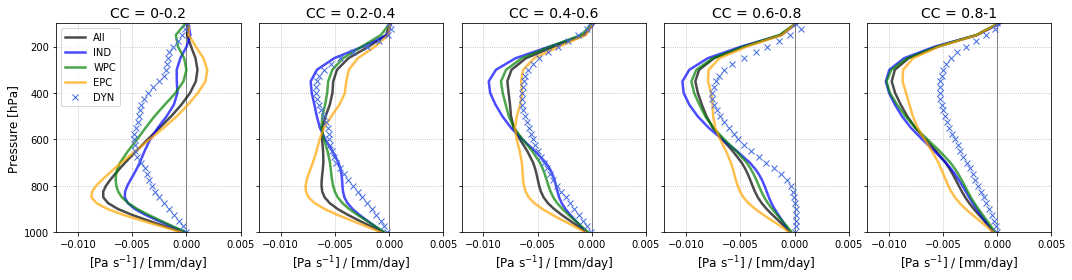

In [38]:
title_txt = ['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
fig,ax = plt.subplots(1,5,figsize=(15,4))
for n in range(5):
    ax[n].plot(omega_com[n,:],lev,'-k',linewidth=2.5,alpha=0.7) 
    ax[n].plot(omega_IND[n,:],lev,'-b',linewidth=2.5,alpha=0.7)
    ax[n].plot(omega_WPC[n,:],lev,'-g',linewidth=2.5,alpha=0.7)
    ax[n].plot(omega_EPC[n,:],lev,'-',color='orange',linewidth=2.5,alpha=0.7)
    ax[n].plot(omega_dynamo[n,:],lev_dyn,'x',color='royalblue')
    ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([])
    if n == 0:
        ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([1000,800,600,400,200])
        ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
        ax[n].legend(['All','IND','WPC','EPC','DYN'],loc=2)
    #ax[n].set_xticks([-0.4,-0.3,-0.2,-0.1,0])
    ax[n].set_ylim([1000,100]);ax[n].set_xlim([-0.012,0.005])
    ax[n].grid(linestyle=':')
    ax[n].set_xlabel('[Pa s$^{-1}$] / [mm/day]',fontsize=12)
    ax[n].set_title('CC = '+title_txt[n],fontsize=14)
    ax[n].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
    
plt.tight_layout(w_pad=0.08)

In [39]:
#fig.savefig(fig_dir+'omega_grouped_vert_M2scaled.pdf',bbox_inches='tight')

In [ ]:
# persistency of mid-level moisture convergence 
# flux convergence at 600hpa binned by cloud coverage, and differnt oceanic regions
cf_bins = np.linspace(0,1,21)
qvflux_600h = np.zeros((len(cf_bins)-1,33))
qvflux_600hstd = np.copy(qvflux_600h)

qvflux_600h_IND = np.copy(qvflux_600h); qvflux_600h_INDstd = np.copy(qvflux_600h)
qvflux_600h_WPC = np.copy(qvflux_600h); qvflux_600h_WPCstd = np.copy(qvflux_600h)
qvflux_600h_EPC = np.copy(qvflux_600h); qvflux_600h_EPCstd = np.copy(qvflux_600h)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[n],cldfrac_all[:,16]<cf_bins[n+1]))[0]
    qvflux_600h[n,:] = np.nanmean(qvflux_all[idx,:,14],axis=(0))
    qvflux_600hstd[n,:] = np.nanstd(qvflux_all[idx,:,14],axis=(0))/np.sqrt(len(idx))
    
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_IND[:,16]>=cf_bins[n],cldfrac_IND[:,16]<cf_bins[n+1]))[0]
    qvflux_600h_IND[n,:] = np.nanmean(qvflux_all[idx_IND[idx],:,14],axis=(0))
    qvflux_600h_INDstd[n,:] = np.nanstd(qvflux_all[idx_IND[idx],:,14],axis=(0))/np.sqrt(len(idx))
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_WPC[:,16]>=cf_bins[n],cldfrac_WPC[:,16]<cf_bins[n+1]))[0]
    qvflux_600h_WPC[n,:] = np.nanmean(qvflux_all[idx_WPC[idx],:,14],axis=(0))
    qvflux_600h_WPCstd[n,:] = np.nanstd(qvflux_all[idx_WPC[idx],:,14],axis=(0))/np.sqrt(len(idx))
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_EPC[:,16]>=cf_bins[n],cldfrac_EPC[:,16]<cf_bins[n+1]))[0]
    qvflux_600h_EPC[n,:] = np.nanmean(qvflux_all[idx_EPC[idx],:,14],axis=(0))
    qvflux_600h_EPCstd[n,:] = np.nanstd(qvflux_all[idx_EPC[idx],:,14],axis=(0))/np.sqrt(len(idx))

In [ ]:
fig = plt.figure(figsize=(6,4))
plt.plot(cf_bins[1:]-0.025,86400*-qvflux_600h[:,16],'k')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h[:,16]+qvflux_600hstd[:,16]),86400*-qvflux_600h[:,16],color='lightgrey')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h[:,16]-qvflux_600hstd[:,16]),86400*-qvflux_600h[:,16],color='lightgrey')

plt.plot(cf_bins[1:]-0.025,86400*-qvflux_600h_IND[:,16],'b')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_IND[:,16]+qvflux_600h_INDstd[:,16]),86400*-qvflux_600h_IND[:,16],color='lightgrey')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_IND[:,16]-qvflux_600h_INDstd[:,16]),86400*-qvflux_600h_IND[:,16],color='lightgrey')

plt.plot(cf_bins[1:]-0.025,86400*-qvflux_600h_WPC[:,16],'g')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_WPC[:,16]+qvflux_600h_WPCstd[:,16]),86400*-qvflux_600h_WPC[:,16],color='lightgrey')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_WPC[:,16]-qvflux_600h_WPCstd[:,16]),86400*-qvflux_600h_WPC[:,16],color='lightgrey')

plt.plot(cf_bins[1:]-0.025,86400*-qvflux_600h_EPC[:,16],color='orange')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_EPC[:,16]+qvflux_600h_EPCstd[:,16]),86400*-qvflux_600h_EPC[:,16],color='lightgrey')
plt.fill_between(cf_bins[1:]-0.025,86400*(-qvflux_600h_EPC[:,16]-qvflux_600h_EPCstd[:,16]),86400*-qvflux_600h_EPC[:,16],color='lightgrey')

plt.hlines(y=0,xmin=0,xmax=1,linewidth=1)
plt.xlabel('Cloud coverage',fontsize=12); plt.ylabel('Mflux Conv. [day$^-1$]',fontsize=12)
plt.xlim([0,1])

### organization effect on mid-level convergence 

In [103]:
N_bins = np.linspace(0,10,6)
cf_bins = np.linspace(0,1,11)
qvflux_600h = np.zeros((len(cf_bins)-1,len(Iorg_bins)-1,33))
qvflux_600hstd = np.copy(qvflux_600h)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[n],cldfrac_all[:,16]<cf_bins[n+1]))[0]
    for j in range(len(Iorg_bins)-1):
        idy = np.where(np.logical_and(N_all[:,16]>=N_bins[j],N_all[:,16]<N_bins[j+1]))[0]
    
        idx_com = np.intersect1d(idx,idy)
        qvflux_600h[n,j,:] = np.nanmean(qvflux_all[idx_com,:,14]/prec_all[idx_com,:],axis=(0)) # normalized flux convergence
        qvflux_600hstd[n,j,:] = np.nanstd(qvflux_all[idx_com,:,14],axis=(0))/np.sqrt(len(idx))

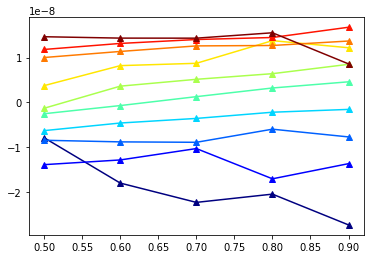

In [104]:
colors= plt.cm.jet(np.linspace(0,1,10))

for n in range(10):
    plt.plot(Iorg_bins[:-1],-qvflux_600h[n,:,16],'-^',color=colors[n])

In [113]:
N_bins = np.linspace(0,10,6)
cf_bins = np.linspace(0,1,6)
omega_com = np.zeros((len(cf_bins)-1,len(N_bins)-1,42))
omega_comstd = np.copy(omega_com)
num_com = np.zeros((len(cf_bins)-1,len(N_bins)-1))

omega_IND = np.copy(omega_com); omega_IND_std = np.copy(omega_com)
omega_WPC = np.copy(omega_com); omega_WPC_std = np.copy(omega_com)
omega_EPC = np.copy(omega_com); omega_EPC_std = np.copy(omega_com)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[n],cldfrac_all[:,16]<cf_bins[n+1]))[0]
    for j in range(len(N_bins)-1):
        idy = np.where(np.logical_and(N_all[:,16]>=N_bins[j],N_all[:,16]<N_bins[j+1]))[0]    
        idx_com = np.intersect1d(idx,idy)

        prec_scale = np.tile((precM2_allre[idx_com]),(42,1)).swapaxes(0,1)
        omega_com[n,j,:] = np.nanmean(omega_all[idx_com,16,:],axis=0)/np.nanmean(prec_scale,axis=0)
        num_com[n,j] = len(idx_com)
    #omega_comstd[n,:] = np.nanstd(omega_all[idx,24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
    
# for n in range(len(cf_bins)-1):
#     idx = np.where(np.logical_and(cldfrac_IND[:,16]>=cf_bins[n],cldfrac_IND[:,16]<cf_bins[n+1]))[0]
#     prec_scale = np.tile((precM2_allre[idx_IND[idx]]),(42,1)).swapaxes(0,1)
#     omega_IND[n,:] = np.nanmean(omega_all[idx_IND[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
#     #omega_IND_std[n] = np.nanstd(omega_all[idx_IND[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
# for n in range(len(cf_bins)-1):
#     idx = np.where(np.logical_and(cldfrac_WPC[:,16]>=cf_bins[n],cldfrac_WPC[:,16]<cf_bins[n+1]))[0]
#     prec_scale = np.tile((precM2_allre[idx_WPC[idx]]),(42,1)).swapaxes(0,1)
#     omega_WPC[n,:] = np.nanmean(omega_all[idx_WPC[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
#     #omega_WPC_std[n,:] = np.nanstd(omega_all[idx_WPC[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))
# for n in range(len(cf_bins)-1):
#     idx = np.where(np.logical_and(cldfrac_EPC[:,16]>=cf_bins[n],cldfrac_EPC[:,16]<cf_bins[n+1]))[0]
#     prec_scale = np.tile((precM2_allre[idx_EPC[idx]]),(42,1)).swapaxes(0,1)
#     omega_EPC[n,:] = np.nanmean(omega_all[idx_EPC[idx],16,:],axis=0)/np.nanmean(prec_scale,axis=0)
#     #omega_EPC_std[n,:] = np.nanstd(omega_all[idx_EPC[idx],24,:]/prec_scale,axis=0)/np.sqrt(len(idx))

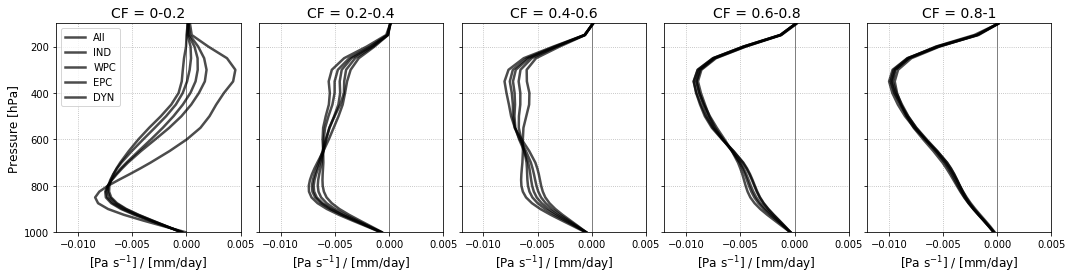

In [118]:
title_txt = ['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
fig,ax = plt.subplots(1,5,figsize=(15,4))
for n in range(5):
    for j in range(5):
        ax[n].plot(omega_com[n,j,:],lev,'-k',linewidth=2.5,alpha=0.7) 
#     ax[n].plot(omega_IND[n,:],lev,'-b',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_WPC[n,:],lev,'-g',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_EPC[n,:],lev,'-',color='orange',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_dynamo[n,:],lev_dyn,'x',color='royalblue')
        ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([])
        if n == 0:
            ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([1000,800,600,400,200])
            ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
            ax[n].legend(['All','IND','WPC','EPC','DYN'],loc=2)
    #ax[n].set_xticks([-0.4,-0.3,-0.2,-0.1,0])
        ax[n].set_ylim([1000,100]);ax[n].set_xlim([-0.012,0.005])
        ax[n].grid(linestyle=':')
        ax[n].set_xlabel('[Pa s$^{-1}$] / [mm/day]',fontsize=12)
        ax[n].set_title('CF = '+title_txt[n],fontsize=14)
        ax[n].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
    
plt.tight_layout(w_pad=0.08)

In [131]:
N_bins = np.linspace(0,10,6)
cf_bins = np.linspace(0,1,6)
div_com = np.zeros((len(cf_bins)-1,len(N_bins)-1,42))
div_comstd = np.copy(div_com)
num_com = np.zeros((len(cf_bins)-1,len(N_bins)-1))

div_IND = np.copy(div_com); div_IND_std = np.copy(div_com)
div_WPC = np.copy(div_com); div_WPC_std = np.copy(div_com)
div_EPC = np.copy(div_com); div_EPC_std = np.copy(div_com)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[n],cldfrac_all[:,16]<cf_bins[n+1]))[0]
    for j in range(len(N_bins)-1):
        idy = np.where(np.logical_and(N_all[:,16]>=N_bins[j],N_all[:,16]<N_bins[j+1]))[0]    
        idx_com = np.intersect1d(idx,idy)

        prec_scale = np.tile((precM2_allre[idx_com]),(42,1)).swapaxes(0,1)
        div_com[n,j,:] = np.nanmean(div_all[idx_com,18,:],axis=0)/np.nanmean(prec_scale,axis=0)
        num_com[n,j] = len(idx_com)

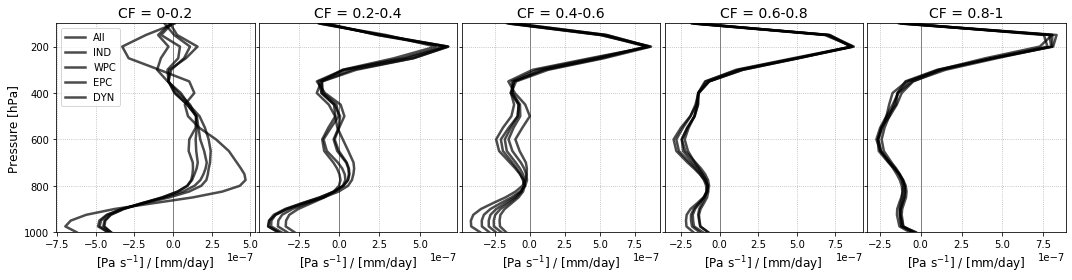

In [132]:
title_txt = ['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
fig,ax = plt.subplots(1,5,figsize=(15,4))
for n in range(5):
    for j in range(5):
        ax[n].plot(div_com[n,j,:],lev,'-k',linewidth=2.5,alpha=0.7) 
#     ax[n].plot(omega_IND[n,:],lev,'-b',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_WPC[n,:],lev,'-g',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_EPC[n,:],lev,'-',color='orange',linewidth=2.5,alpha=0.7)
#     ax[n].plot(omega_dynamo[n,:],lev_dyn,'x',color='royalblue')
        ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([])
        if n == 0:
            ax[n].set_yticks([1000,800,600,400,200]);ax[n].set_yticklabels([1000,800,600,400,200])
            ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
            ax[n].legend(['All','IND','WPC','EPC','DYN'],loc=2)
    #ax[n].set_xticks([-0.4,-0.3,-0.2,-0.1,0])
        ax[n].set_ylim([1000,100])#;ax[n].set_xlim([-0.012,0.005])
        ax[n].grid(linestyle=':')
        ax[n].set_xlabel('[Pa s$^{-1}$] / [mm/day]',fontsize=12)
        ax[n].set_title('CF = '+title_txt[n],fontsize=14)
        ax[n].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
    
plt.tight_layout(w_pad=0.08)

In [ ]:
Amp = np.zeros((qvflux_600h.shape[0],33))
for n in range(20):
    Amp[n,:] = -qvflux_600h[n,:]/-qvflux_600h[n,16] # factor

e_fold = np.zeros(len(Amp))    
for n in range(20):
    idx = np.where(Amp[n,16:]<1/np.e)[0]
    try:
        e_fold[n] = idx[0]
    except:
        e_fold[n] = np.nan

for n in range(10,20):
    plt.plot(np.linspace(-48,48,33),Amp[n,:])
plt.legend(['1','2','3','4','5','6','7','8','9','10'])
plt.xlim([0,48])

### Omega vertical mode decomposition [Masunaga and L'ecuyer]

In [ ]:
def vertmode_omega(omega_data,omega_bg,fbc_mtx):
    'omega_bg: background omega profile'
    m_dim = fbc_mtx.shape[0]
    t_dim = omega_data.shape[0]
    m_time = np.zeros((m_dim,t_dim))
    omega_rcst = np.zeros(omega_data.shape) # reconstructed profile by three modes 
    for t in range(t_dim):
        omega_mtx = np.matrix((omega_data[t,:25]-omega_bg[:25]))
        m_mtx = (fbc_mtx*fbc_mtx.T).I*(fbc_mtx*omega_mtx.T) # regression coefficient    
        m_time[:,t] = m_mtx.A.T
        omega_rcst[t,:] = m_mtx.T*fbc_mtx
    return m_time, omega_rcst

In [ ]:
# prescribed vertical mode definition
ps = 1000
ptp = 100
p = lev[:25]
fbc1 = -np.sin(1*np.pi*(p-ptp)/(ps-ptp)) # prescribed first mode
fbc2 = -np.sin(2*np.pi*(p-ptp)/(ps-ptp)) # prescribed second mode 
fshl = -np.sin(np.pi*(p-800)/(ps-800)); fshl[8:] = 0 # prescribed shallow mode, peak at 900hpa
fbc_mtx = np.stack((fbc1,fbc2,fshl),axis=0)
fbc_mtx = np.matrix(fbc_mtx)

In [ ]:
fig = plt.figure(figsize=(5,4.5))
plt.plot(fbc1,p,'-k',linewidth=2,alpha=0.8)
plt.plot(fbc2,p,'--k',linewidth=2,alpha=0.8)
plt.plot(fshl,p,':k',linewidth=2,alpha=0.8)
plt.ylim([1000,100]);plt.vlines(x=0,ymax=1000,ymin=100,linewidth=0.5)
plt.legend(['F$_1$, dc','F$_2$, st','F$_3$, cu'],fontsize=12,frameon=False)
plt.ylabel('Pressure [hPa]',fontsize=12)

In [ ]:
#fig.savefig(fig_dir+'Verticalmode_functions.pdf',bbox_inches='tight')

In [ ]:
omega_allmn = np.nanmean(omega_all,axis=0)
omega_bg = np.nanmean(np.concatenate((omega_allmn[:4,:25],omega_allmn[-4:,:25])),axis=0)

In [ ]:
em1_time = np.zeros(prec_all.shape)
em2_time = np.zeros(prec_all.shape)
em3_time = np.zeros(prec_all.shape)

for n in range(len(omega_all)):
    m_time, omega_rcst = vertmode_omega(omega_all[n,:,:25],omega_bg,fbc_mtx)
    em1_time[n,:] = m_time[0,:]
    em2_time[n,:] = m_time[1,:]
    em3_time[n,:] = m_time[2,:]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-48,48,33),np.nanmean(em1_time,axis=0)/100*3600,'-k')
plt.plot(np.linspace(-48,48,33),np.nanmean(em2_time,axis=0)/100*3600,'--k')
plt.plot(np.linspace(-48,48,33),np.nanmean(em3_time,axis=0)/100*3600,':k')
plt.hlines(y=0,xmin=-48,xmax=48,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-48,48]);plt.ylim([-1,3]);plt.xticks(np.arange(-48,60,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
#fig.savefig(fig_dir+'vertmode_coeff_allevents.pdf',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

#plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_call_all,axis=0),'-xk')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_cu_all,axis=0),':k')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_dc_all,axis=0),'--k')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_st_all,axis=0),'-k')
plt.hlines(y=0,xmin=-48,xmax=48,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')
ax.set_ylim([0,80])
plt.xlim([-48,48]);plt.xticks(np.arange(-48,60,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
plt.legend(['cu','dc','st'],loc=1)

In [ ]:
plt.plot(np.nanmean(cldamt_cu_all,axis=0)/(np.nanmean(cldamt_call_all,axis=0)-np.nanmean(cldamt_dc_all,axis=0)
                                           -np.nanmean(cldamt_st_all,axis=0)))

In [ ]:
np.nanmean(cldamt_cu_all/(cldamt_call_all-cldamt_dc_all-cldamt_st_all),axis=0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_dc_all,axis=0),'-k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_st_all,axis=0),'--k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_cu_all,axis=0),':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')
ax.set_ylim([0,30])

ax2 = ax.twinx()
ax2.plot(np.linspace(-72,72,49),np.nanmean(cldamt_cu_all,axis=0)/(np.nanmean(cldamt_call_all,axis=0)-np.nanmean(cldamt_dc_all,axis=0)
                                           -np.nanmean(cldamt_st_all,axis=0)),'-k',linewidth=0.6)
#ax2.plot(np.linspace(-72,72,49),100*np.nanmean(cldamt_cu_all/(cldamt_call_all-cldamt_dc_all-cldamt_st_all)
#                                           ,axis=0),'-k',linewidth=0.8)
ax2.set_ylabel('Cu fraction',fontsize=12)

plt.xlim([-72,72]);ax2.set_ylim([0,0.3]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
#fig.savefig(fig_dir+'vertmode_cldamt_allevents.pdf',bbox_inches='tight')

In [ ]:
em1_g1 = np.nanmean(em1_time[idx_G1,:],axis=0)
em2_g1 = np.nanmean(em2_time[idx_G1,:],axis=0)
em3_g1 = np.nanmean(em3_time[idx_G1,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g1/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g1/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g1/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
callamt_g1 = np.nanmean(cldamt_call_all[idx_G1,:],axis=0)
cuamt_g1 = np.nanmean(cldamt_cu_all[idx_G1,:],axis=0)
stamt_g1 = np.nanmean(cldamt_st_all[idx_G1,:],axis=0)
dcamt_g1 = np.nanmean(cldamt_dc_all[idx_G1,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),callamt_g1,'-xk')
plt.plot(np.linspace(-72,72,49),dcamt_g1,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g1,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g1,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,60]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g3 = np.nanmean(em1_time[idx_G3,:],axis=0)
em2_g3 = np.nanmean(em2_time[idx_G3,:],axis=0)
em3_g3 = np.nanmean(em3_time[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g3/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g3/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g3/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt_g3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt_g3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g3,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g3,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g3,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,50]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g4 = np.nanmean(em1_time[idx_G4,:],axis=0)
em2_g4 = np.nanmean(em2_time[idx_G4,:],axis=0)
em3_g4 = np.nanmean(em3_time[idx_G4,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g4/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g4/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g4/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g4 = np.nanmean(cldamt_cu_all[idx_G4,:],axis=0)
stamt_g4 = np.nanmean(cldamt_st_all[idx_G4,:],axis=0)
dcamt_g4 = np.nanmean(cldamt_dc_all[idx_G4,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g4,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g4,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g4,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,45]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
cuamt_g2 = np.nanmean(cldamt_cu_all[idx_G2,:],axis=0)
stamt_g2 = np.nanmean(cldamt_st_all[idx_G2,:],axis=0)
dcamt_g2 = np.nanmean(cldamt_dc_all[idx_G2,:],axis=0)

em1_g2 = np.nanmean(em1_time[idx_G2,:],axis=0)
em2_g2 = np.nanmean(em2_time[idx_G2,:],axis=0)
em3_g2 = np.nanmean(em3_time[idx_G2,:],axis=0)

cuamt_g5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt_g5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt_g5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)

em1_g5 = np.nanmean(em1_time[idx_G5,:],axis=0)
em2_g5 = np.nanmean(em2_time[idx_G5,:],axis=0)
em3_g5 = np.nanmean(em3_time[idx_G5,:],axis=0)

In [ ]:
# plot cloud amount for all categories
plt.plot(np.linspace(-72,72,49),stamt_g1)
plt.plot(np.linspace(-72,72,49),stamt_g2)
plt.plot(np.linspace(-72,72,49),stamt_g3)
plt.plot(np.linspace(-72,72,49),stamt_g4)
plt.plot(np.linspace(-72,72,49),stamt_g5)
plt.xlim([0,72])

In [ ]:
plt.plot(np.linspace(-72,72,49),em2_g1)
plt.plot(np.linspace(-72,72,49),em2_g2)
plt.plot(np.linspace(-72,72,49),em2_g3)
plt.plot(np.linspace(-72,72,49),em2_g4)
plt.plot(np.linspace(-72,72,49),em2_g5)
plt.xlim([0,72])

In [ ]:
re_stats = np.zeros((6,3,2))
re_stats[0,0,:] = np.asarray(pearsonr(em1_g1,dcamt_g1))
re_stats[0,1,:] = np.asarray(pearsonr(em2_g1,stamt_g1))    
re_stats[0,2,:] = np.asarray(pearsonr(em3_g1,cuamt_g1))    
re_stats[1,0,:] = np.asarray(pearsonr(em1_g2,dcamt_g2))    
re_stats[1,1,:] = np.asarray(pearsonr(em2_g2,stamt_g2))    
re_stats[1,2,:] = np.asarray(pearsonr(em3_g2,cuamt_g2))    
re_stats[2,0,:] = np.asarray(pearsonr(em1_g3,dcamt_g3))    
re_stats[2,1,:] = np.asarray(pearsonr(em2_g3,stamt_g3))    
re_stats[2,2,:] = np.asarray(pearsonr(em3_g3,cuamt_g3))    
re_stats[3,0,:] = np.asarray(pearsonr(em1_g4,dcamt_g4))    
re_stats[3,1,:] = np.asarray(pearsonr(em2_g4,stamt_g4))    
re_stats[3,2,:] = np.asarray(pearsonr(em3_g4,cuamt_g4))    
re_stats[4,0,:] = np.asarray(pearsonr(em1_g5,dcamt_g5))    
re_stats[4,1,:] = np.asarray(pearsonr(em2_g5,stamt_g5))    
re_stats[4,2,:] = np.asarray(pearsonr(em3_g5,cuamt_g5)) 

In [ ]:
import pandas as pd

In [ ]:
d = {'coeff_m1': re_stats[:,0,0],'p_m1': re_stats[:,0,1],
     'coeff_m2': re_stats[:,1,0],'p_m2': re_stats[:,1,1],
     'coeff_m3': re_stats[:,2,0],'p_m3': re_stats[:,2,1]}
df = pd.DataFrame(data = d)

In [ ]:
df

In [ ]:
colors = ['k','r','g','b','m']
symbals = ['x','o','^','d','s']
for n in range(5):
    plt.plot(range(3),re_stats[n,:,0],linestyle='',
             color=colors[n],marker=symbals[n],markersize=10)
plt.ylim([-1.2,1.2])

In [ ]:
fig = plt.figure(figsize=(12,3))
clevs=np.linspace(-0.09,0.015,15)*3600/100
plt.contourf(np.linspace(-72,72,49),lev,3600/100*np.nanmean(omega_all,axis=0).T,levels=clevs,
            cmap='RdBu_r',clim=(-0.09*36,0.015*36),norm=MidpointNormalize(midpoint=0,vmin=-0.09*36, vmax=0.015*36))
plt.ylim([1000,100]);cbar = plt.colorbar(pad=0.02,shrink=0.8)
cbar.set_label('[hPa/hr]')
plt.ylabel('Pressure [hPa]');plt.xlabel('hour')
fig.savefig(fig_dir+'omega_profile_exp.pdf',bbox_inches='tight')

In [ ]:
cuamt3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)
toamt3 = cuamt3+stamt3+dcamt3

plt.plot(np.convolve(cuamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
cuamt5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)
toamt5 = cuamt5+stamt5+dcamt5

plt.plot(np.convolve(cuamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
-----------------------------------------------

In [ ]:
def caseview(time_event,lat_event,lon_event):

    data_sub1 = subset_MERRA2(MERRA2_3d_dir+'TQUV_3hr'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub5 = subset_gridsat(Gridsat_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,3,10,20)
    
    u_sm = data_sub1.U
    v_sm = data_sub1.V
    T_sm = data_sub1.T
    q_sm = data_sub1.QV
    prec_sm = data_sub2.precipitation.resample(time='6H').nearest()
    cwv_sm = data_sub3.TQV.resample(time='6H').nearest()
    omega_sm = data_sub4.OMEGA
    bt_sm = data_sub5.irwin_cdr.resample(time='6H').nearest()

    u_950sm = u_sm.sel(lev=950).resample(time='6H').nearest()
    v_950sm = v_sm.sel(lev=950).resample(time='6H').nearest()
    u_tar = u_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    v_tar = v_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    omega_tar = omega_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    prec_tar = prec_sm.sel(nlon=slice(lon_event-5,lon_event+5),nlat=slice(lat_event-5,lat_event+5))
    bt_tar = bt_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    SCAIbt_sm,SCAI_p,Nbt_sm,N_prec = SCAI_index(prec_tar,bt_tar) # 6H data
    div_tar = np.gradient(u_tar,0.625*100*1e3,axis=3)+np.gradient(v_tar,0.5*100*1e3,axis=2) # divergence 3D
    
    p = T_sm.lev.values*units('mbar')
    T_tar = T_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    q_tar = q_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    # cape/cin calculation
    cape_sm = np.zeros(len(T_tar.time))
    cin_sm = np.copy(cape_sm)
    for t in range(len(u_tar.time)):
        T_tmp = np.nanmean(T_tar[t,:,:,:],axis=(1,2))
        q_tmp = np.nanmean(q_tar[t,:,:,:],axis=(1,2))
        T = (T_tmp-273.15)*units('degC')
        q = q_tmp*units('kg/kg')
        Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q))
        
        try:
            Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC')                    
            el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
            el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))                
            ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
            [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
            cape_sm[t] = CAPE.magnitude
            cin_sm[t] = CIN.magnitude
        except:
            cape_sm[t] = np.nan
            cin_sm[t] = np.nan
    
    # Abar calculation
    tmp = bt_tar.values
    cldfrac_sm = [len(np.where(tmp[n,:,:]<240)[0])/(tmp.shape[1]*tmp.shape[2]) for n in range(tmp.shape[0])]
    Abar_sm = cldfrac_sm/Nbt_sm*1600
    
    return (u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm
            ,div_tar,cape_sm,cin_sm)

In [ ]:
idx_G1[4000:4100]

In [ ]:
num=16890
u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm,div_sm,cape_sm,cin_sm = caseview(time_event[num],lat_event[num],lon_event[num])

In [ ]:
fig,ax = plt.subplots(7,2,figsize=(12,15))

label = np.arange(0,7)
timelabel = np.array([11,12,13,14,15,16,17])

for n,t in zip(label,timelabel):
    #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax[n,0].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
    ax[n,0].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45],colors=['w'])
    ax[n,0].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
    rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,0].add_patch(rect1)
    if n ==0:
        ax[n,0].set_title(time_event[num])
        
    ax[n,1].contour(prec_sm.nlon,prec_sm.nlat,prec_sm[t,:,:].transpose(),
                   levels=[1,5,10,30,50],linewidths=1,colors=['m'])
    tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
    ax[n,1].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
    rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,1].add_patch(rect2)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+7.5,'N = '+str(int(Nbt_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+5.5,'SCAI = '+str(round(SCAIbt_sm[t],1)),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+3.5,'Abar = '+str(round(Abar_sm[t],1)),color='g',fontsize=11)
    if n ==0:
        ax[n,1].set_title(time_event[num])

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
SFX_bin = np.zeros((len(cldfrac_bin)-1,48)) # m/s
SFXstd_bin = np.zeros((len(cldfrac_bin)-1,48))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    SFX_bin[n,:] = np.nanmean(SFX_all[idx,:],axis=0)
    SFXstd_bin[n,:] = np.nanmean(SFXstd_all[idx,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
wsfc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    wsfc_bin[n,:] = np.nanmean((u_all[idx,:,0]**2+v_all[idx,:,0]**2)**0.5,axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
# cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
# freq_bin = np.zeros((len(cldfrac_bin)-1,4)) # m/s

# for n in range(len(cldfrac_bin)-1):
#     idx1 = np.where(np.logical_and(cldfrac_DJF[:,24]>=cldfrac_bin[n],cldfrac_DJF[:,24]<cldfrac_bin[n+1]))[0]
#     idx2 = np.where(np.logical_and(cldfrac_MAM[:,24]>=cldfrac_bin[n],cldfrac_MAM[:,24]<cldfrac_bin[n+1]))[0]
#     idx3 = np.where(np.logical_and(cldfrac_JJA[:,24]>=cldfrac_bin[n],cldfrac_JJA[:,24]<cldfrac_bin[n+1]))[0]
#     idx4 = np.where(np.logical_and(cldfrac_SON[:,24]>=cldfrac_bin[n],cldfrac_SON[:,24]<cldfrac_bin[n+1]))[0]
    
#     freq_bin[n,0] = len(idx1)
#     freq_bin[n,1] = len(idx2)
#     freq_bin[n,2] = len(idx3)
#     freq_bin[n,3] = len(idx4)

In [ ]:
# constructing the climatology over targeted scenes for T,q,RH anomaly 
# to remove seasonality and diurnal cycle
os.chdir(MERRA2_dir+'inst_2d_hourly')
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

In [ ]:
cwv = data.sel(lat=slice(-20,20)).TQV
cwv_clim = cwv.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# test for removing seasonality over all cases
cwv_rmseason = np.copy(cwv_all)

for n in range(len(time_event)):
    cwv_climsub = cwv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    cwv_rmseason[n,:] = cwv_all[n,:] - cwv_climsub.mean().values

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cwva_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cwvastd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cwva_bin[n,:] = np.nanmean(cwv_all[idx,:],axis=0)
    cwvastd_bin[n,:] = np.nanstd(cwv_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)

fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
# prec anomaly vs cwv anomaly
fig = plt.figure(figsize=(6,6))

plt.plot(cwva_bin[0,:],preca_bin[0,:],'-k',linewidth=0.6)
plt.scatter(cwva_bin[0,:],preca_bin[0,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[1,:],preca_bin[1,:],'-r',linewidth=0.6)
plt.scatter(cwva_bin[1,:],preca_bin[1,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[2,:],preca_bin[2,:],'-g',linewidth=0.6)
plt.scatter(cwva_bin[2,:],preca_bin[2,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[3,:],preca_bin[3,:],'-b',linewidth=0.6)
plt.scatter(cwva_bin[3,:],preca_bin[3,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')

In [ ]:
# open T_clim, qv_clim, RH_clim 
os.chdir('/w2-data/willytsai/ISCCP/')
T_clim = xr.open_dataset('T_clim_10deg.nc')
qv_clim = xr.open_dataset('qv_clim_10deg.nc')
RH_clim = xr.open_dataset('rh_clim_10deg.nc')

In [ ]:
T_rmseason = np.copy(T_all)

for n in range(len(time_event)):
    T_climsub = T_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).T
    T_rmseason[n,:,:] = (T_all[n,:,:] - T_climsub.mean(axis=(1,2)).values)

In [ ]:
q_rmseason = np.copy(q_all)

for n in range(len(time_event)):
    q_climsub = qv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).QV
    q_rmseason[n,:,:] = q_all[n,:,:] - q_climsub.mean(axis=(1,2)).values

In [ ]:
rh_rmseason = np.copy(rh_all)

for n in range(len(time_event)):
    rh_climsub = RH_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).RH
    rh_rmseason[n,:,:] = rh_all[n,:,:] - rh_climsub.mean(axis=(1,2)).values

In [ ]:
# os.chdir(MERRA2_3d_dir+'RH_3hr')
# files = glob('*nc4')
# data = xr.open_mfdataset(files)

In [ ]:
# %%time
# rh = data.sel(lon=slice(50,90),lat=slice(-10,10)).RH
# rh_clim = rh.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# os.chdir('/w2-data/willytsai/ISCCP')
# m2data = np.loadtxt('MERRA2_modellevs.txt')
# m2lev = np.flipud(m2data[:,1])

In [ ]:
# for m in range(12):
#     plt.plot(np.nanmean(rh_clim[m,:,:,:],axis=(1,2)),m2lev,zorder=1)
# plt.ylim([1000,150])
# plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
for m in range(12):
    plt.plot(qv_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
u = data.sel(lon=slice(50,90),lat=slice(-10,10)).U
u_clim = u.groupby('time.month').mean('time').compute() # climatology of daily data

u_rmseason = np.copy(u_all)

for n in range(len(time_event)):
    u_climsub = u_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    u_rmseason[n,:] = u_all[n,:,:] - u_climsub.mean(axis=(1,2)).values

In [ ]:
for m in range(12):
    plt.plot(u_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150]);plt.vlines(0,ymax=1000,ymin=0,zorder=2)
plt.xlim([-10,10])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
lev_model = np.loadtxt('MERRA2_modellevs.txt')[:,1]

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
rha_bin = np.zeros((len(cldfrac_bin)-1,49,72)) # m/s
rhastd_bin = np.zeros((len(cldfrac_bin)-1,49,72))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    rha_bin[n,:,:] = np.nanmean(rh_all[idx,:,:],axis=0)
    rhastd_bin[n,:,:] = np.nanstd(rh_all[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(0.3,1,8)
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[0,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[1,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[2,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[3,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
qa_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
qastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    qa_bin[n,:,:] = np.nanmean(q_rmseason[idx,:,:],axis=0)
    qastd_bin[n,:,:] = np.nanstd(q_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(-1,1,21)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[0,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[1,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[2,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[3,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()

#plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
#          ,fontsize=9)
#plt.ylabel('CWV anomaly [mm]')
#plt.xlabel('Lag time [hr]')
#plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
Ta_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
Tastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    Ta_bin[n,:,:] = np.nanmean(T_rmseason[idx,:,:],axis=0)
    Tastd_bin[n,:,:] = np.nanstd(T_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs1 = np.linspace(-0.5,0.5,21)

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()


In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cape_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
capestd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cape_bin[n,:] = np.nanmean(cape_all[idx,:],axis=0)
    capestd_bin[n,:] = np.nanstd(cape_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
div_regress = np.zeros((len(time_event),49,42))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        for k in range(div_regress.shape[2]): # vertical dims
            tmp = prec_all[t,:];tmp2 = div_all[t,:,k]
            pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
            if len(pp) > 0: # not empty
                reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
                div_regress[t,:,k] = np.asarray(reg)
            else:
                div_regress[t,:,k] = np.nan

In [ ]:
# divergence evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
div_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    div_bin[n,:,:] = np.nanmean(div_regress[idx,:,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))
clevs = np.linspace(-0.6,0.6,17)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[0,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[1,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[2,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[3,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

In [ ]:
# build cloud types climatology
os.chdir(ISCCP_dir)
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

cldamt_types = data.cldamt_types.sel(lat=slice(-10,10),lon=slice(50,90))
cldamt_cu = cldamt_types[:,0,:,:] + cldamt_types[:,3,:,:]
cldamt_st = cldamt_types[:,13,:,:] + cldamt_types[:,16,:,:]
cldamt_dc = cldamt_types[:,14,:,:] + cldamt_types[:,17,:,:]

cu_clim = cldamt_cu.groupby('time.month').mean('time').compute() # climatology of daily data
st_clim = cldamt_st.groupby('time.month').mean('time').compute()
dc_clim = cldamt_dc.groupby('time.month').mean('time').compute()

cu_rmseason = np.copy(cldamt_cu_all)
st_rmseason = np.copy(cu_rmseason)
dc_rmseason = np.copy(cu_rmseason)

In [ ]:
for n in range(len(time_event)):
    cu_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    st_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    dc_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    
    cu_rmseason[n,:] = cldamt_cu_all[n,:] - cu_climsub.mean(axis=(0,1)).values
    st_rmseason[n,:] = cldamt_st_all[n,:] - st_climsub.mean(axis=(0,1)).values
    dc_rmseason[n,:] = cldamt_dc_all[n,:] - dc_climsub.mean(axis=(0,1)).values

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
cldamt_cu_regress = np.zeros((len(time_event),49))
cldamt_st_regress = np.zeros((len(time_event),49))
cldamt_dc_regress = np.zeros((len(time_event),49))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_cu_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_cu_regress[t,:] = np.asarray(reg)
        else:
            cldamt_cu_regress[t,:] = np.nan
            
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_st_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_st_regress[t,:] = np.asarray(reg)
        else:
            cldamt_st_regress[t,:] = np.nan

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_dc_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_dc_regress[t,:] = np.asarray(reg)
        else:
            cldamt_dc_regress[t,:] = np.nan

In [ ]:
# cloud type evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cldamt_cu_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_st_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_dc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cldamt_cu_bin[n,:] = np.nanmean(cldamt_cu_regress[idx,:],axis=0)
    cldamt_st_bin[n,:] = np.nanmean(cldamt_st_regress[idx,:],axis=0)    
    cldamt_dc_bin[n,:] = np.nanmean(cldamt_dc_regress[idx,:],axis=0)
    num_bin[n] = len(idx)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,6))

ax[0,0].plot(cldamt_cu_bin[0,:],'k')
ax[0,0].plot(cldamt_st_bin[0,:],'b')
ax[0,0].plot(cldamt_dc_bin[0,:],'r')

ax[0,1].plot(cldamt_cu_bin[1,:],'k')
ax[0,1].plot(cldamt_st_bin[1,:],'b')
ax[0,1].plot(cldamt_dc_bin[1,:],'r')

ax[1,0].plot(cldamt_cu_bin[2,:],'k')
ax[1,0].plot(cldamt_st_bin[2,:],'b')
ax[1,0].plot(cldamt_dc_bin[2,:],'r')

ax[1,1].plot(cldamt_cu_bin[3,:],'k')
ax[1,1].plot(cldamt_st_bin[3,:],'b')
ax[1,1].plot(cldamt_dc_bin[3,:],'r')

plt.show()

In [ ]:
lon_event.min()